<a href="https://colab.research.google.com/github/kevinPoliPoli/federated-learning-project/blob/main/centralized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

## <strong>Dependencies and imports<strong/>
</div>


**Install requirements**

In [13]:

!pip3 install 'torch'
!pip3 install 'torchvision'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

!pip3 install torchinfo


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import libraries**

In [14]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt 
from statistics import mean 

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchinfo import summary
from torch.utils.data import random_split
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

from PIL import Image
from tqdm import tqdm

<div class="markdown-google-sans">

## <strong>Hyper-parameters and transformations<strong/>
</div>

**Set Arguments**

In [15]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 100    # 101: There is am extra Background class that should be removed 

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.1                # The initial Learning Rate
MOMENTUM = 0.9          # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.0001   # Regularization, you can keep this at the default

NUM_EPOCHS = 160   # Total number of training epochs (iterations over dataset)

STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 5

AUG_PROB = 0.5   # the probability with witch each image is transformed at training time during each epoch
AUG_TYPE = None      # define the type  of augmentation pipeline 
                     # None for no data augmentation

**Define Data Preprocessing and Augmentation**

In [16]:
# Define transforms for training phase
train_transform = transforms.Compose([ transforms.ToTensor()   # Remember this when applying different transformations, otherwise you get an error
])

#normalizeTest = transforms.Normalize((0.5089, 0.4874, 0.4419), (0.2683, 0.2574, 0.2771))
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([ transforms.ToTensor(),   # Remember this when applying different transformations, otherwise you get an error
#normalizeTest
])

**FData augmentation**

In [17]:
rc_t = transforms.RandomCrop(32, padding=4)
hflip_t = transforms.RandomHorizontalFlip(p = 1)
normalizer = transforms.Normalize(mean = (0.5071, 0.4867, 0.4408), std= (0.2675, 0.2565, 0.2761))

aug_transformation = transforms.Compose([hflip_t, rc_t])

aug_pipeline = transforms.Compose([   transforms.ToPILImage(),
                                      transforms.RandomApply([aug_transformation], p = AUG_PROB),
                                      transforms.ToTensor(),
                                      normalizer
                                  ])

**Prepare Dataset**

In [18]:
from sklearn.model_selection import train_test_split

# Prepare Pytorch train/test Datasets
TRAIN_DATASET = CIFAR100(root="data", train=True, download=True, transform=train_transform)
TEST_DATASET = CIFAR100(root="data", train=False, download=True, transform=eval_transform)

train_set, val_set, _ = random_split(TRAIN_DATASET, [45000, 5000, 50000-len(TRAIN_DATASET)])

# Check dataset sizes
print('-----------------------------------------')
print('CIFAR100 TRAIN Dataset: {}'.format(len(TRAIN_DATASET)))
print('CIFAR100 TEST Dataset: {}'.format(len(TEST_DATASET)))
print('-----------------------------------------')
print('Train Dataset: {}'.format(len(train_set)))
print('Valid Dataset: {}'.format(len(val_set)))
print('Test Dataset: {}'.format(len(TEST_DATASET)))

Files already downloaded and verified
Files already downloaded and verified
-----------------------------------------
CIFAR100 TRAIN Dataset: 50000
CIFAR100 TEST Dataset: 10000
-----------------------------------------
Train Dataset: 45000
Valid Dataset: 5000
Test Dataset: 10000


**Prepare Dataloaders**

In [19]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(TEST_DATASET, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

351
40
79


<div class="markdown-google-sans">

## <strong>ResNet definition<strong/>
</div>

Res net 20

In [20]:
import sys
import torch.nn as nn
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

from functools import partial
from typing import Dict, Type, Any, Callable, Union, List, Optional

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.gn1 = nn.GroupNorm(2, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.gn2 = nn.GroupNorm(2, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.gn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class CifarResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super(CifarResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = conv3x3(3, 16)
        self.gn1 = nn.GroupNorm(2, 16)  
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.GroupNorm(2, planes * block.expansion),  
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(
    layers: List[int],
) -> CifarResNet:
    model = CifarResNet(BasicBlock, layers)


    return model

<div class="markdown-google-sans">

## <strong>Training<strong/>
</div>

**Prepare Training**

In [21]:
#net = ResNet20(100).cuda(); # first implementation
net = _resnet([3]*3) # second implementation

net_summary = summary(net, input_size=(BATCH_SIZE,3,32,32), depth=4) 
print(str(net_summary)) #show the model architecture

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
parameters_to_optimize = net.parameters()

# Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
T_max = NUM_EPOCHS
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0.00000015)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, STEP_SIZE, eta_min=0.000015)

Layer (type:depth-idx)                   Output Shape              Param #
CifarResNet                              [128, 100]                --
├─Conv2d: 1-1                            [128, 16, 32, 32]         432
├─GroupNorm: 1-2                         [128, 16, 32, 32]         32
├─ReLU: 1-3                              [128, 16, 32, 32]         --
├─Sequential: 1-4                        [128, 16, 32, 32]         --
│    └─BasicBlock: 2-1                   [128, 16, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 16, 32, 32]         2,304
│    │    └─GroupNorm: 3-2               [128, 16, 32, 32]         32
│    │    └─ReLU: 3-3                    [128, 16, 32, 32]         --
│    │    └─Conv2d: 3-4                  [128, 16, 32, 32]         2,304
│    │    └─GroupNorm: 3-5               [128, 16, 32, 32]         32
│    │    └─ReLU: 3-6                    [128, 16, 32, 32]         --
│    └─BasicBlock: 2-2                   [128, 16, 32, 32]         --
│    │  

**Validation**

In [22]:

def evaluate(net, dataloader, last_accuracy, update, print_tqdm = True):
  
  with torch.no_grad():
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode
    running_corrects = 0
    iterable = tqdm(dataloader) if print_tqdm else dataloader
    losses = []
    for images, labels in iterable: 
      norm_images = []
      for image in images:
        norm_image = normalizer(image)
        norm_images.append(norm_image)
      norm_images = torch.stack(norm_images)  
      norm_images = norm_images.to(DEVICE)
      labels = labels.to(DEVICE)
      # Forward Pass
      outputs = net(norm_images)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    # Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))
    if update is True:
      if accuracy > last_accuracy:
        torch.save(net.state_dict(), f"{net.__class__.__name__}-gn-cifar100.pth")
        last_accuracy = accuracy
        print("model updated")
      else:
        print("model not updated")

  return accuracy, mean(losses), last_accuracy

In [23]:

def evaluateTest(net, dataloader, print_tqdm = True):
  normalizeTest = transforms.Normalize((0.5089, 0.4874, 0.4419), (0.2683, 0.2574, 0.2771))
  net.load_state_dict(torch.load(f"{net.__class__.__name__}-gn-cifar100.pth"))
  with torch.no_grad():
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode
    running_corrects = 0
    iterable = tqdm(dataloader) if print_tqdm else dataloader
    losses = []
    for images, labels in iterable: 
      norm_images = []
      for image in images:
        norm_image = normalizeTest(image)
        norm_images.append(norm_image)
      norm_images = torch.stack(norm_images)  
      norm_images = norm_images.to(DEVICE)
      labels = labels.to(DEVICE)
      # Forward Pass
      outputs = net(norm_images)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    # Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))

    

  return accuracy, mean(losses)

**Train and Validation**

In [24]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0

val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []
last_accuracy = 0

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    
    aug_images = []

    for image in images:
      aug_image = aug_pipeline(image).to(DEVICE)
      aug_images.append(aug_image) 

    aug_images = torch.stack(aug_images)

    # Bring data over the device of choice
    aug_images = aug_images.to(DEVICE)
    

    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(aug_images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  train_acc, train_loss, _ = evaluate(net, train_dataloader, last_accuracy, update=False, print_tqdm = False)
  train_accuracies.append(train_acc)
  train_losses.append(train_loss)
  
  val_acc, val_loss, last_accuracy = evaluate(net, val_dataloader, last_accuracy, update=True, print_tqdm = False)
  val_accuracies.append(val_acc)
  val_losses.append(val_loss)

  # Step the scheduler
  scheduler.step() 


Output streaming troncato alle ultime 5000 righe.
Step 31855, Loss 1.0524754524230957
Step 31860, Loss 0.7011505365371704
Step 31865, Loss 0.9448589086532593
Step 31870, Loss 0.7264536619186401
Step 31875, Loss 0.942328929901123
Step 31880, Loss 0.9760012626647949
Step 31885, Loss 1.089676856994629
Step 31890, Loss 1.090157389640808
Step 31895, Loss 0.8627643585205078
Step 31900, Loss 1.239313006401062
Step 31905, Loss 1.0593458414077759
Step 31910, Loss 0.8231433033943176
Step 31915, Loss 1.0023901462554932
Step 31920, Loss 0.8384928703308105
Step 31925, Loss 1.2001214027404785
Step 31930, Loss 1.0109575986862183
Step 31935, Loss 1.0297131538391113
Step 31940, Loss 0.8253280520439148
model updated
Starting epoch 92/160, LR = [0.03928463341993392]
Step 31945, Loss 0.8404992818832397
Step 31950, Loss 1.04150390625
Step 31955, Loss 0.8770989775657654
Step 31960, Loss 0.7692509889602661
Step 31965, Loss 0.9814978241920471
Step 31970, Loss 0.7774585485458374
Step 31975, Loss 1.094875931739

Best accuracies on the validation set:  0.5838


<Axes: xlabel='epoch'>

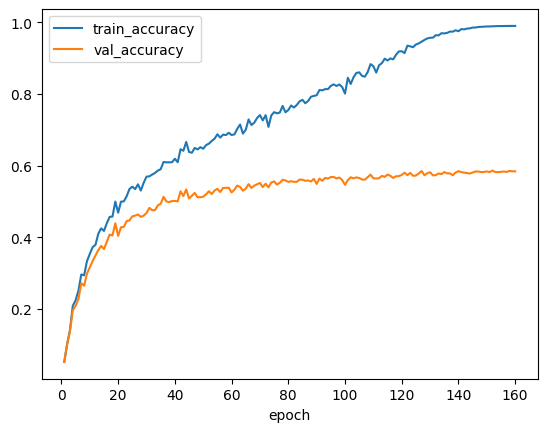

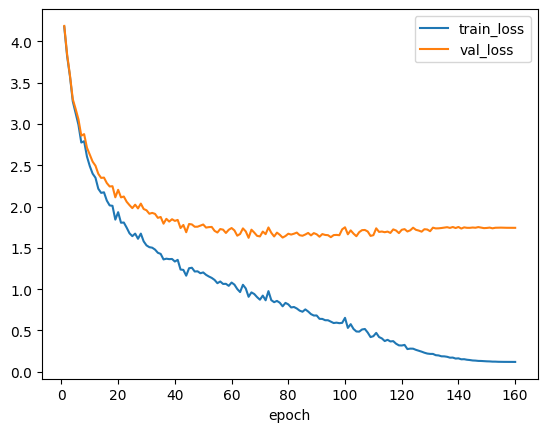

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

print("Best accuracies on the validation set: ", val_acc)

results_df = pd.DataFrame(zip(range(1,NUM_EPOCHS+1), train_accuracies, val_accuracies, train_losses, val_losses), columns = ["epoch", "train_accuracy", "val_accuracy", "train_loss", "val_loss"])
results_df.set_index("epoch")
results_df.plot(x = "epoch", y = ["train_accuracy", "val_accuracy"])
results_df.plot(x = "epoch", y = ["train_loss", "val_loss"])

**Test**

In [26]:
state_dict = torch.load(f"{net.__class__.__name__}-gn-cifar100.pth")
net.load_state_dict(state_dict)
accuracy = evaluateTest(net, test_dataloader)[0]
print('\nTest Accuracy: {}'.format(accuracy))

100%|██████████| 79/79 [00:02<00:00, 27.06it/s]


Test Accuracy: 0.595
